In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.datasets import AirPassengersDataset
%cd ..
%ls

/home/mahdigilany/offline_codes/codes/ts_snr
configs/  main.py     OLD/       requirements.txt  slurm_logs/  wandb/
logs/     notebooks/  README.md  scripts/          src/


In [20]:
from src.data.registry.data_registry import create_dataset, DataSeries
data_series: DataSeries = create_dataset('exchange_rate', split_ratio=(0.7,0.1,0.2), use_scaler=False) # TimeSeries class object

In [21]:
train, val, test = data_series.train_series, data_series.val_series, data_series.test_series
print(train._xa.shape, val._xa.shape, test._xa.shape)
print(train._xa.mean().values.reshape(-1), val._xa.mean().values.reshape(-1), test._xa.mean().values.reshape(-1))
print(train._xa.std().values.reshape(-1), val._xa.std().values.reshape(-1), test._xa.std().values.reshape(-1))
# print(train._xa.mean(axis=0).values.reshape(-1), val._xa.mean(axis=0).values.reshape(-1), test._xa.mean(axis=0).values.reshape(-1))
# print(train._xa.std(axis=0).values.reshape(-1), val._xa.std(axis=0).values.reshape(-1), test._xa.std(axis=0).values.reshape(-1))

(5309, 8, 1) (760, 8, 1) (1519, 8, 1)
[0.6641286] [0.7996599] [0.7488479]
[0.47794217] [0.47785708] [0.45592457]


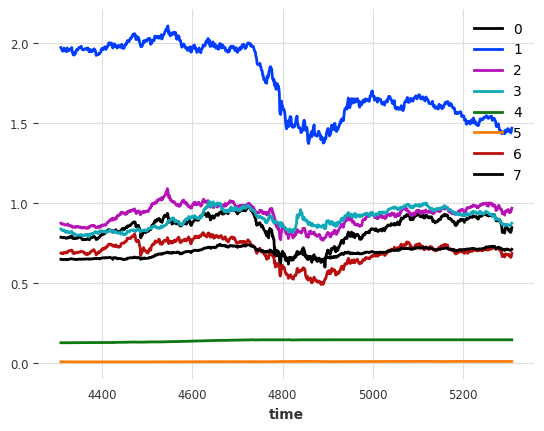

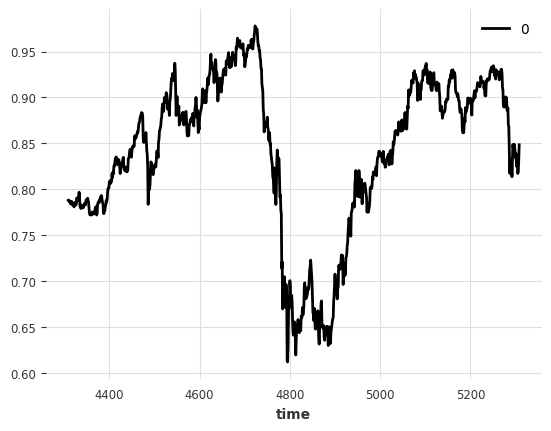

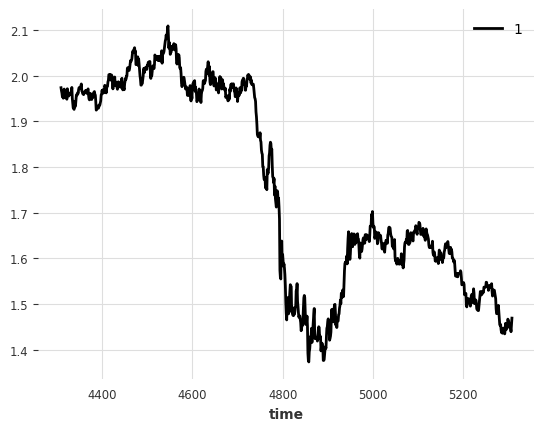

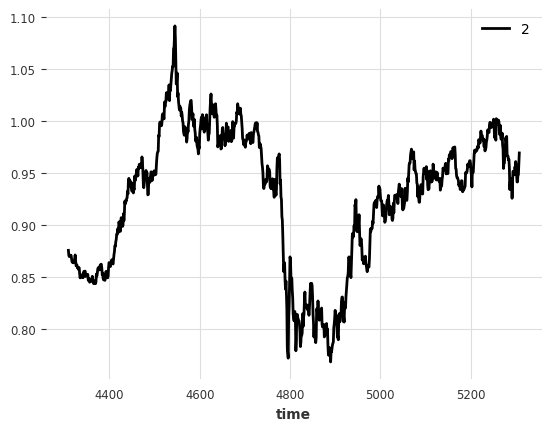

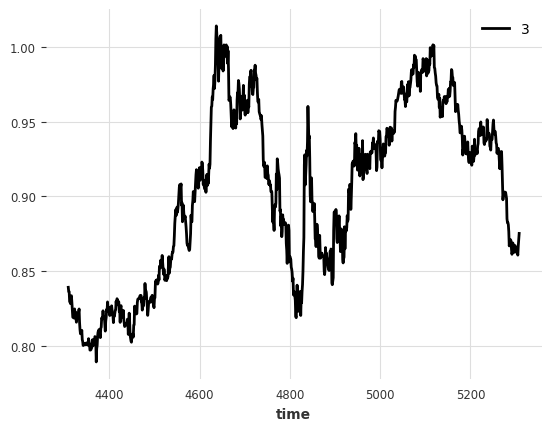

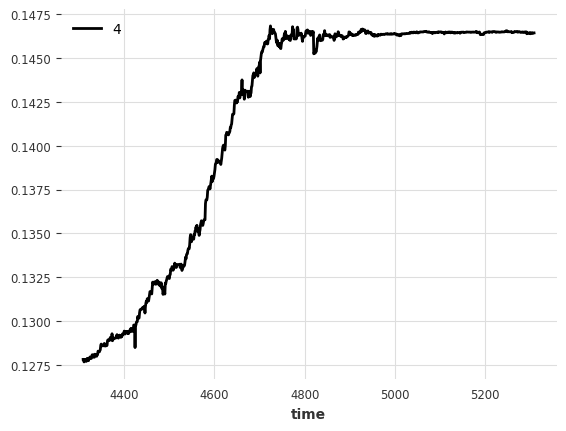

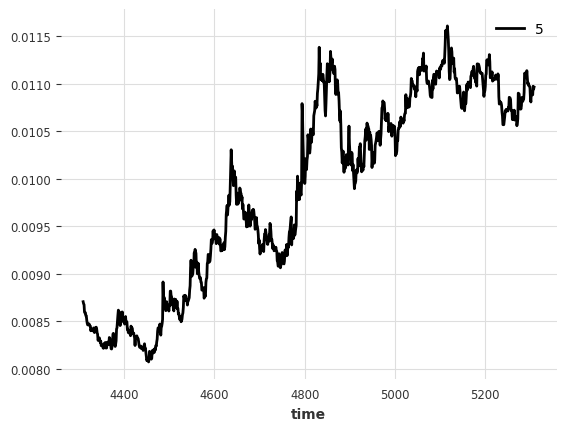

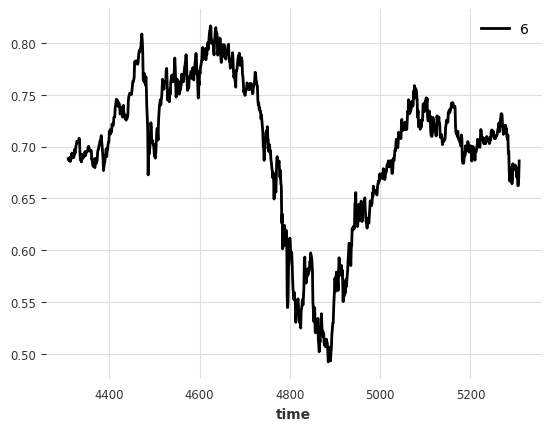

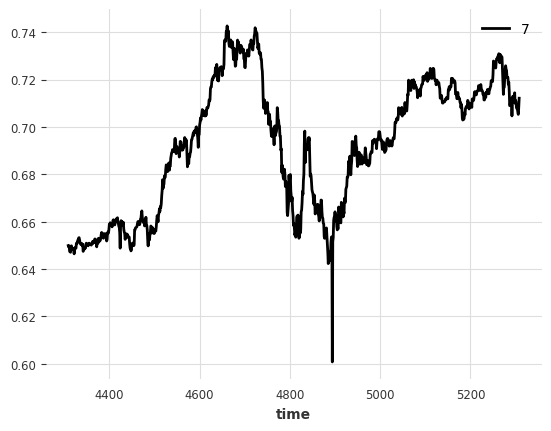

In [22]:
train[-1000:].plot()
# val[-1000:].plot()
# test[-1000:].plot()
for i, component in enumerate(test.components):
    if i>10: 
        break
    plt.figure()
    train[component][-1000:].plot(label=component)
    # val[component][-1000:].plot(label=component)
    # test[component][-1000:].plot(label=component)

Number of components is larger than 10 (862). Plotting only the first 10 components.


(12278, 862, 1)

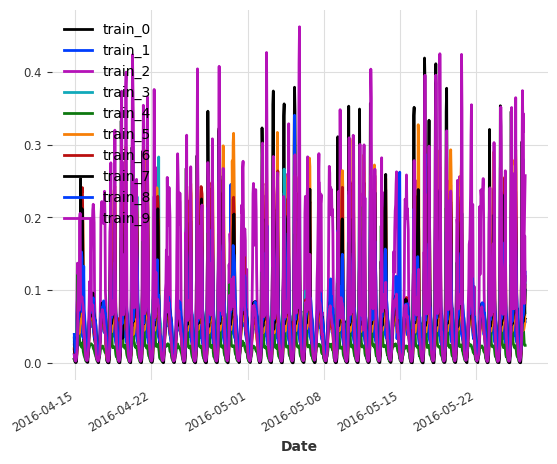

In [12]:
train_ts: TimeSeries = data_series.train_series
val_ts = data_series.val_series
test_ts = data_series.test_series
train_ts[-1000:].plot(label='train')    
# train_ts._xa.sel({'component':['HUFL']})
train_ts._xa.values.shape
# train_ts.plot(label='train')
# val_ts.plot(label='val')

In [ ]:
i_th_run = -1
exp_name = f"deeptime_airpassenger"
main_dir = f"logs/experiments/runs/{exp_name}"
main_dir = os.path.join(os.getcwd(), main_dir)
work_dir = glob(os.path.join(main_dir, "**/darts_logs"), recursive=True)
config_dir = glob(os.path.join(main_dir, "**/config.yaml"), recursive=True)
config_dir = [dir for dir in config_dir if "wandb" not in dir]
work_dir = work_dir[i_th_run]
config_dir = config_dir[i_th_run]
config_dir

In [ ]:
from omegaconf import OmegaConf
from src.driver.drivers import inference_darts_lightning_driver_run

config = OmegaConf.load(config_dir)
config.logger = None
model, data, metrics = inference_darts_lightning_driver_run(config)

In [ ]:
train, val, *scaler = data
model.load_weights_from_checkpoint(config.model.model_name, work_dir=work_dir) # don't use load_from_checkpoint since needs logger and produces error
pred = model.predict(series=train, n=36)
pred_on_val = model.predict(series=val[:24], n=12) # we need such a thing for evaluating the results

train.plot(label="train")
val.plot(label="val")
pred.plot(label="forecast")
pred_on_val.plot(label="forecast on val")


In [68]:
model.fit(train_ts, verbose=True, epochs=50, num_loader_workers=0, val_series=val_ts)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | inr              | INR              | 1.3 M 
4 | adaptive_weights | RidgeRegressor   | 1     
------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.258     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 77.77it/s, train_loss=0.0344]

/home/mahdigilany/anaconda3/envs/borealis/lib/python3.9/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


Epoch 1: 100%|██████████| 3/3 [00:00<00:00, 90.36it/s, train_loss=0.0295, val_loss=0.133, val_MeanAbsolutePercentageError=0.244, train_MeanAbsolutePercentageError=0.506]

/home/mahdigilany/anaconda3/envs/borealis/lib/python3.9/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 59.62it/s, train_loss=0.00393, val_loss=0.0688, val_MeanAbsolutePercentageError=0.239, train_MeanAbsolutePercentageError=0.144]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 39.02it/s, train_loss=0.00393, val_loss=0.0688, val_MeanAbsolutePercentageError=0.239, train_MeanAbsolutePercentageError=0.144]


DeepTIMeModel(datetime_feats=0, layer_size=256, inr_layers=5, n_fourier_feats=4096, scales=[0.01, 0.1, 1, 5, 10, 20, 50, 100], input_chunk_length=24, output_chunk_length=12, random_state=0, batch_size=32, save_checkpoints=True, torch_metrics=MetricCollection(
  (MeanAbsolutePercentageError): MeanAbsolutePercentageError()
), pl_trainer_kwargs={'num_sanity_val_steps': 0}, model_name=deeptime, force_reset=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


None
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.74it/s]
Mean absolute percentage error: 24.95%.
Mean absolute percentage error: 18.88%.


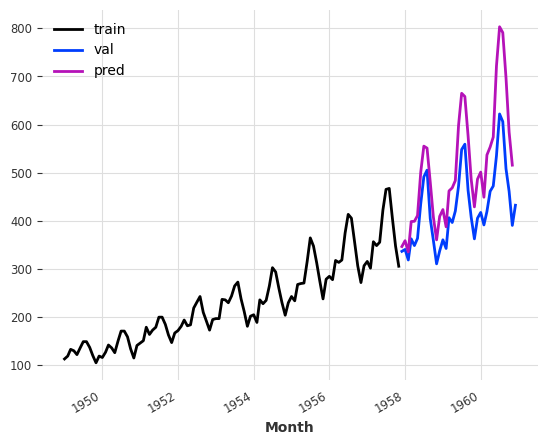

In [22]:
from src.modeling.models.deep_time import DeepTIMeModel


noisestd = 0
seed = 0
exp_name = f"deeptime_airpassenger_noisestd{noisestd}_seed{seed}"
dir = f"logs/experiments/runs/{exp_name}"
work_dir = os.path.join(os.getcwd(), dir)
work_dir = glob(os.path.join(work_dir, "**/*.ckpt"), recursive=True)[-2]

exp_name = f"deeptime_airpassenger"
dir = f"logs/experiments/runs/{exp_name}"
work_dir = os.path.join(os.getcwd(), dir)
work_dir = glob(os.path.join(work_dir, "**/darts_logs"), recursive=True)[2]

# exp_name = f"nbeats_airpassenger"
# dir = f"logs/experiments/runs/{exp_name}"
# work_dir = os.path.join(os.getcwd(), dir)
# work_dir = glob(os.path.join(work_dir, "**/darts_logs"), recursive=True)[0]


# model = model.load_from_checkpoint(model_name="deeptime", work_dir=work_dir, best=True)
model.load_weights_from_checkpoint(model_name="deeptime", work_dir=work_dir, best=True)
print(model.load_ckpt_path)
pred = model.predict(series=train_ts, n=36)

from darts.metrics import mape as mape_fn
print(
    "Mean absolute percentage error: {:.2f}%.".format(
        mape_fn(val_ts, pred)
    )
)

# scale back:
train_unscaled_ts = scaler.inverse_transform(train_ts)
val_unscaled_ts = scaler.inverse_transform(val_ts)
pred = scaler.inverse_transform(pred)

from darts.metrics import mape as mape_fn
print(
    "Mean absolute percentage error: {:.2f}%.".format(
        mape_fn(val_unscaled_ts, pred)
    )
)

train_unscaled_ts.plot(label='train')
val_unscaled_ts.plot(label='val')
pred.plot(label='pred')
